In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from keras.applications import EfficientNetB7
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py

In [2]:
keras.__version__

'2.10.0'

In [3]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [4]:
in_dir = "D:/COLLEGE SEM 8/Datasets/Hockey Fight dataset"

In [5]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video

# Frames to Be considered for each Dataset:
# Fight Surf Data - 20
# Bus Violence Data - 16
# RWF 2000 Data - 60
# RLVS Data - 20
# Peliculas (Movies) - 30
# Hockey Fights - 30
# Crowd Violence - 20

_images_per_file = 30

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [6]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [7]:
def label_video_namesHockey(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [8]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    Classes = ["NonViolence","Violence"]
    
    def listdir_nohidden(path):
        for f in os.listdir(path):
            if not f.startswith('.'):
                yield f
            
    for category in listdir_nohidden(in_dir):
        path = os.path.join(in_dir, category)
        for current_dir, dir_names,file_names in os.walk(path):
            for file_name in file_names:
                if category == 'Violence':
                    labels.append([1,0])
                    names.append(os.path.join("Violence",file_name))
                elif category == 'NonViolence':
                    labels.append([0,1])
                    names.append(os.path.join("NonViolence",file_name))
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [9]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

In [10]:
names[12]

'Violence\\fi446_xvid.avi'

In [11]:
frames = get_frames(in_dir, names[12])

In [12]:
visible_frame = (frames*255).astype('uint8')

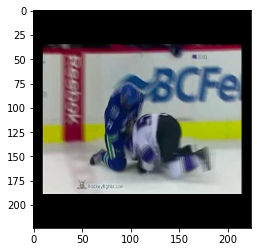

In [13]:
plt.imshow(visible_frame[3])

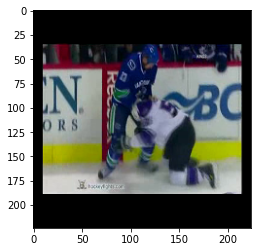

In [14]:
plt.imshow(visible_frame[15])

In [15]:
input_tensor = keras.layers.Input(shape=(img_size,img_size,num_channels))
image_model = VGG16(include_top=True, weights='imagenet', input_tensor=input_tensor)

In [16]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [18]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [19]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([_images_per_file,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [20]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('VGG16hockey.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [21]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('VGG16hockeytest.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [25]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [26]:
make_files(training_set)

1/1 [==============================] - 4s 4s/step
- Progress: 99.9%

In [27]:
make_files_test(test_set)

1/1 [==============================] - 4s 4s/step
- Progress: 99.5%

In [22]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=_images_per_file
    count = 0
    
    with h5py.File('C:/Users/vnktv.000/Desktop/VGG16_Fulldata/Extracted Files/VGG16HockeyFulldata.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [23]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=_images_per_file
    count = 0
    
    with h5py.File('VGG16hockeytest.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [24]:
data, target = process_alldata_training()

In [25]:
x = len(data)
x = int(x*0.8)
train_data = data[0:x]
train_target = target[0:x]
test_data = data[x:]
test_target = target[x:]

In [26]:
print(x)
print(len(data))
print(len(train_data))
print(len(test_data))

800
1000
800
200


In [27]:
chunk_size = 4096
n_chunks = _images_per_file
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [29]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

checkpoint_filepath = 'EfficientNetModleCheckspeliculas3.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)
callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [30]:
n = len(data)
n

1000

In [31]:
epoch = 200
batchS = 64
n = len(train_data)
n = int(n*0.9)
history = model.fit(np.array(train_data[0:n]), np.array(train_target[0:n]), epochs=epoch,
                    validation_data=(np.array(train_data[n:]), np.array(train_target[n:])), 
                    batch_size=batchS, verbose=2, callbacks=callbacks)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.22946, saving model to EfficientNetModleCheckspeliculas3.h5
12/12 - 13s - loss: 0.2416 - accuracy: 0.6736 - val_loss: 0.2295 - val_accuracy: 0.8250 - lr: 1.0000e-05 - 13s/epoch - 1s/step
Epoch 2/200

Epoch 2: val_loss improved from 0.22946 to 0.19225, saving model to EfficientNetModleCheckspeliculas3.h5
12/12 - 9s - loss: 0.2105 - accuracy: 0.8708 - val_loss: 0.1922 - val_accuracy: 0.8625 - lr: 1.8000e-05 - 9s/epoch - 759ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.19225 to 0.13631, saving model to EfficientNetModleCheckspeliculas3.h5
12/12 - 9s - loss: 0.1571 - accuracy: 0.8944 - val_loss: 0.1363 - val_accuracy: 0.8375 - lr: 2.6000e-05 - 9s/epoch - 760ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.13631 to 0.10458, saving model to EfficientNetModleCheckspeliculas3.h5
12/12 - 9s - loss: 0.1033 - accuracy: 0.8931 - val_loss: 0.1046 - val_accuracy: 0.8750 - lr: 3.4000e-05 - 9s/epoch - 757ms/step
Epoch 5/200

Epoch 5:

In [32]:
result = model.evaluate(np.array(test_data), np.array(test_target))

7/7 [==============================] - 1s 203ms/step - loss: 0.0690 - accuracy: 0.9000


In [33]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.06897063553333282
accuracy 0.8999999761581421


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


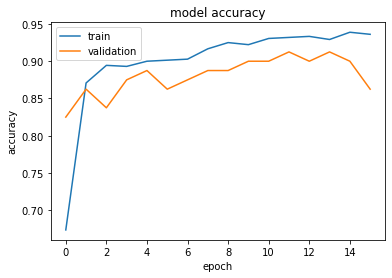

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


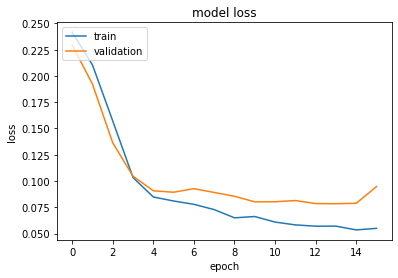

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [36]:
np.shape(test_data)

(200, 30, 4096)

In [37]:
import tensorflow as tf
preds = []
tt = tf.unstack(test_data,axis=0)
print(np.shape(tt))
print(np.shape(tt[0]))

(200, 30, 4096)
(30, 4096)


In [38]:
ttl = []
for i in tt:
    x = tf.reshape(i,(-1,30,4096))
    print(np.shape(x))
    ttl.append(x)

(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30, 4096)
(1, 30

In [39]:
for i in ttl:
    x = model.predict(i)
    preds.append(x)

1/1 [==============================] - 0s 34ms/step


In [40]:
predictions = np.array(preds)

In [41]:
np.shape(predictions)

(200, 1, 2)

In [42]:
for i in predictions:
    print(i)

[[0.06613258 0.93386745]]
[[0.05919554 0.9408045 ]]
[[0.9393839  0.06061605]]
[[0.07274985 0.9272502 ]]
[[0.92019814 0.07980186]]
[[0.93254316 0.06745683]]
[[0.9413816 0.0586184]]
[[0.08220205 0.9177979 ]]
[[0.8987162  0.10128383]]
[[0.06227287 0.93772715]]
[[0.9421005  0.05789954]]
[[0.71183246 0.28816754]]
[[0.9421187  0.05788125]]
[[0.10095859 0.89904135]]
[[0.07249448 0.92750555]]
[[0.92603636 0.07396366]]
[[0.10071575 0.89928424]]
[[0.06282049 0.93717957]]
[[0.06002409 0.93997586]]
[[0.15049168 0.84950835]]
[[0.9323879  0.06761213]]
[[0.9258654 0.0741346]]
[[0.9407431  0.05925686]]
[[0.12174451 0.8782555 ]]
[[0.3107225 0.6892775]]
[[0.07771002 0.92228997]]
[[0.92869794 0.07130203]]
[[0.05886707 0.94113296]]
[[0.05541943 0.9445805 ]]
[[0.94381255 0.05618738]]
[[0.07133667 0.92866325]]
[[0.68687767 0.31312236]]
[[0.05937753 0.9406225 ]]
[[0.05316366 0.9468363 ]]
[[0.15430976 0.84569025]]
[[0.07227884 0.9277212 ]]
[[0.62631786 0.3736822 ]]
[[0.43267512 0.5673249 ]]
[[0.94203025 0.057

In [43]:
predictions = predictions > 0.5

In [44]:
for i in predictions:
    print(i)

[[False  True]]
[[False  True]]
[[ True False]]
[[False  True]]
[[ True False]]
[[ True False]]
[[ True False]]
[[False  True]]
[[ True False]]
[[False  True]]
[[ True False]]
[[ True False]]
[[ True False]]
[[False  True]]
[[False  True]]
[[ True False]]
[[False  True]]
[[False  True]]
[[False  True]]
[[False  True]]
[[ True False]]
[[ True False]]
[[ True False]]
[[False  True]]
[[False  True]]
[[False  True]]
[[ True False]]
[[False  True]]
[[False  True]]
[[ True False]]
[[False  True]]
[[ True False]]
[[False  True]]
[[False  True]]
[[False  True]]
[[False  True]]
[[ True False]]
[[False  True]]
[[ True False]]
[[ True False]]
[[ True False]]
[[False  True]]
[[ True False]]
[[False  True]]
[[False  True]]
[[ True False]]
[[ True False]]
[[ True False]]
[[ True False]]
[[ True False]]
[[ True False]]
[[False  True]]
[[False  True]]
[[False  True]]
[[False  True]]
[[False  True]]
[[ True False]]
[[False  True]]
[[ True False]]
[[False  True]]
[[ True False]]
[[False  True]]
[[False 

In [45]:
predictions = predictions.astype(int)

In [46]:
for i in predictions:
    print(i)

[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]
[[0 1]]
[[0 1]]
[[1 0]]
[[0 1]]
[[0 1]]
[[0 1]]
[[1 0]]
[[1 0]]
[[1 0]]


In [47]:
np.shape(predictions)

(200, 1, 2)

In [48]:
np.shape(test_target)

(200, 2)

In [50]:
preds2 = predictions.reshape(200,2)

In [51]:
np.shape(preds2)

(200, 2)

In [52]:
for i in preds2:
    print(i)

[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1

In [53]:
tv = np.array(test_target,dtype=int)
for i in tv:
    print(i)

[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[0 1

In [54]:
report = classification_report(tv,preds2,target_names=["NonViolence", "Violence"])

In [55]:
print(report)

              precision    recall  f1-score   support

 NonViolence       0.92      0.88      0.90       102
    Violence       0.88      0.92      0.90        98

   micro avg       0.90      0.90      0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200
 samples avg       0.90      0.90      0.90       200

